# **Reprise de l'exemple fourni** : Sentence Embedding

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Chargement des données

(14640, 14)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,14640,14485,0,1.000000,0.989413,int64
airline_sentiment,14640,3,0,1.000000,0.000205,object
airline_sentiment_confidence,14640,1023,0,1.000000,0.069877,float64
negativereason,9178,10,5462,0.626913,0.001090,object
negativereason_confidence,10522,1410,4118,0.718716,0.134005,float64
airline,14640,6,0,1.000000,0.000410,object
airline_sentiment_gold,40,3,14600,0.002732,0.075000,object
name,14640,7701,0,1.000000,0.526025,object
negativereason_gold,32,13,14608,0.002186,0.406250,object
retweet_count,14640,18,0,1.000000,0.001230,int64


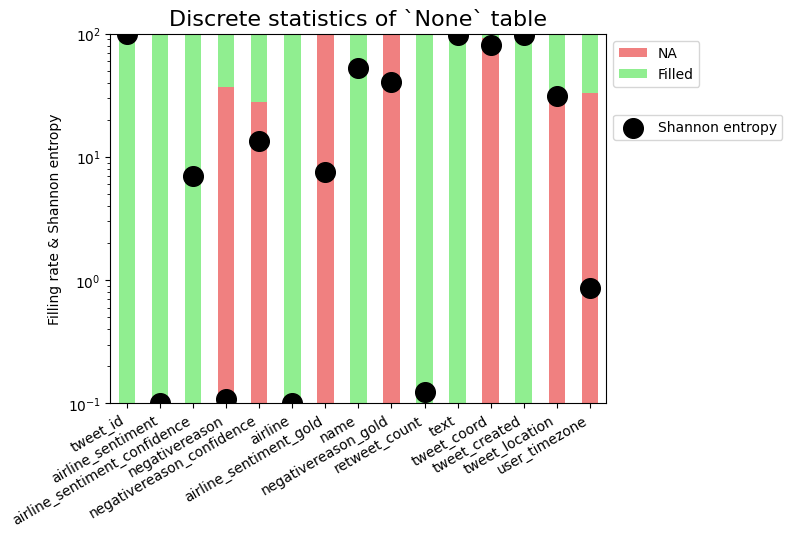

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
569701192449654784,negative,1.0,Customer Service Issue,1.0000,US Airways,NaN,UnluckyDon,NaN,0,@USAirways Instructions say to CALL. I'm just ...,NaN,2015-02-22 19:32:03 -0800,"Santa Cruz, CA",NaN
567767201286205441,neutral,1.0,NaN,NaN,Southwest,NaN,realMattHolt,NaN,0,@SouthwestAir chances of flight leaving BNA to...,NaN,2015-02-17 11:27:04 -0800,nyc/nashville/san diego,Eastern Time (US & Canada)
569988987420434432,negative,1.0,Customer Service Issue,0.6491,US Airways,NaN,mitchsunderland,NaN,0,@USAirways great. I just called your fucking p...,NaN,2015-02-23 14:35:39 -0800,"Florida Raised, NYC Based",London
568095956866093057,neutral,1.0,NaN,NaN,United,NaN,thereal_SNL,NaN,0,@united if I have credit from a flight I Cance...,NaN,2015-02-18 09:13:25 -0800,District of Columbia,Eastern Time (US & Canada)
569487757741051904,negative,1.0,Can't Tell,0.6561,US Airways,NaN,corybronze,NaN,1,@USAirways This was a real life exercise in cr...,NaN,2015-02-22 05:23:56 -0800,NaN,NaN


In [3]:
from tx_ml import load
from pepper_utils import show_discrete_stats

raw_tweets = load('Tweets.csv')
print(raw_tweets.shape)
show_discrete_stats(raw_tweets.reset_index())
display(raw_tweets.sample(5))

## Filtrage sur un niveau de confiance maximal du sentiment

In [4]:
raw_tweets.airline_sentiment_confidence.value_counts(normalize=True)

1.0000    0.713456
0.6667    0.004850
0.6632    0.002391
0.6596    0.002049
0.6559    0.002049
            ...   
0.3674    0.000068
0.6155    0.000068
0.3708    0.000068
0.6905    0.000068
0.3487    0.000068
Name: airline_sentiment_confidence, Length: 1023, dtype: float64

In [5]:
# Filtre de tweets avec un niveau de confiance à 1 sur le sentiment
import pandas as pd
raw_tweets = raw_tweets[raw_tweets.airline_sentiment_confidence == 1]

print(raw_tweets.shape)
vc = pd.concat([
    raw_tweets.airline_sentiment.value_counts().rename('#'),
    raw_tweets.airline_sentiment.value_counts(normalize=True).rename('%')
], axis=1)
display(vc)

(10445, 14)


,#,%
negative,7382,0.706750
neutral,1548,0.148205
positive,1515,0.145045


# Echantillonage

Ehantillon de 3000 tweets, associés à un sentiment pour moitié positif, pour moitié négatif.

In [6]:
from tx_ml import old_3k_sample, tweets_3k_sample

rt_old_3k_sample = old_3k_sample(raw_tweets)
rt_3k_sample = tweets_3k_sample(raw_tweets)

(3000, 14)

(3000, 14)

# Nettoyage du texte

In [7]:
from tx_ml import preprocess, save_as

preprocess(rt_old_3k_sample)
preprocess(rt_3k_sample)

save_as(rt_old_3k_sample, 'old_3k_sample_clean.csv')
save_as(rt_3k_sample, '3k_sample_clean.csv')

# Préparation commune des traitements

## Lecture dataset

(3000, 17)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,3000,2988,0,1.000000,0.996000,int64
airline_sentiment,3000,2,0,1.000000,0.000667,object
airline_sentiment_confidence,3000,1,0,1.000000,0.000333,float64
negativereason,1500,10,1500,0.500000,0.006667,object
negativereason_confidence,1500,520,1500,0.500000,0.346667,float64
airline,3000,6,0,1.000000,0.002000,object
airline_sentiment_gold,6,2,2994,0.002000,0.333333,object
name,3000,2481,0,1.000000,0.827000,object
negativereason_gold,4,3,2996,0.001333,0.750000,object
retweet_count,3000,9,0,1.000000,0.003000,int64


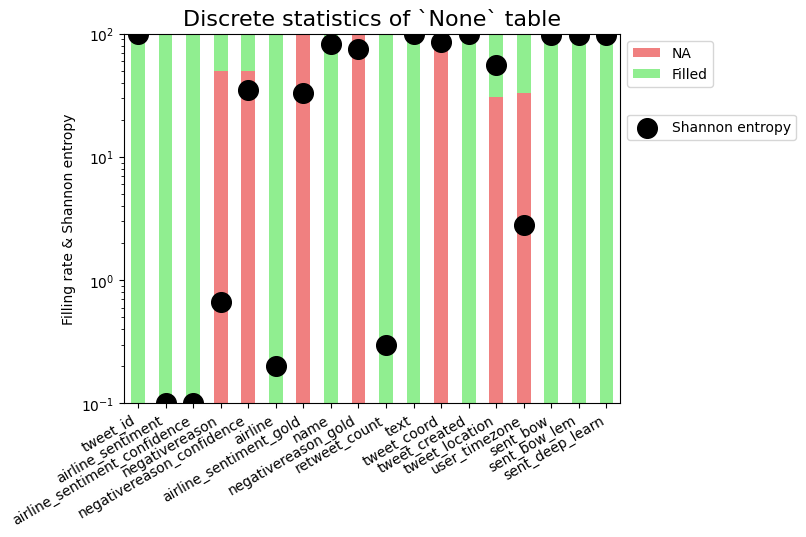

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,,,,,,,,,,,,,,,
569540050821763072,positive,1.0,NaN,NaN,Delta,NaN,contimike,NaN,0,@JetBlue they were amazing and thank you!,NaN,2015-02-22 08:51:44 -0800,"New York, sort of!",NaN,jetblue amazing thank,jetblue amazing thank,jetblue they were amazing and thank you !
569470757673291777,negative,1.0,Lost Luggage,1.000,United,NaN,tu_huynh,NaN,0,"@united still missing my luggage, was promised...",NaN,2015-02-22 04:16:23 -0800,"Washington, DC",Eastern Time (US & Canada),united still missing luggage promised someone ...,united still missing luggage promised someone ...,"united still missing my luggage , was promised..."
568575427742011392,negative,1.0,Cancelled Flight,0.658,United,NaN,pvb29,NaN,0,@united silence is very telling,NaN,2015-02-19 16:58:40 -0800,NaN,NaN,united silence telling,united silence telling,united silence is very telling
569260280687005697,negative,1.0,Cancelled Flight,1.000,Southwest,NaN,jvancequ,NaN,0,@SouthwestAir are ur flight still Cancelled Fl...,NaN,2015-02-21 14:20:01 -0800,NaN,NaN,southwestair flight still cancelled flight nas...,southwestair flight still cancelled flight nas...,southwestair are ur flight still cancelled fli...
570307876897628160,positive,1.0,NaN,NaN,United,NaN,rdowning76,NaN,0,@united thanks,NaN,2015-02-24 11:42:48 -0800,usa,NaN,united thanks,united thanks,united thanks


In [8]:
from tx_ml import load
from pepper_utils import show_discrete_stats

tweets = load('3k_sample_clean.csv')
print(tweets.shape)
show_discrete_stats(tweets.reset_index())
display(tweets.sample(5))

(3000, 17)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
tweet_id,3000,2990,0,1.000000,0.996667,int64
airline_sentiment,3000,2,0,1.000000,0.000667,object
airline_sentiment_confidence,3000,1,0,1.000000,0.000333,float64
negativereason,1500,10,1500,0.500000,0.006667,object
negativereason_confidence,1500,522,1500,0.500000,0.348000,float64
airline,3000,6,0,1.000000,0.002000,object
airline_sentiment_gold,5,2,2995,0.001667,0.400000,object
name,3000,2180,0,1.000000,0.726667,object
negativereason_gold,3,3,2997,0.001000,1.000000,object
retweet_count,3000,9,0,1.000000,0.003000,int64


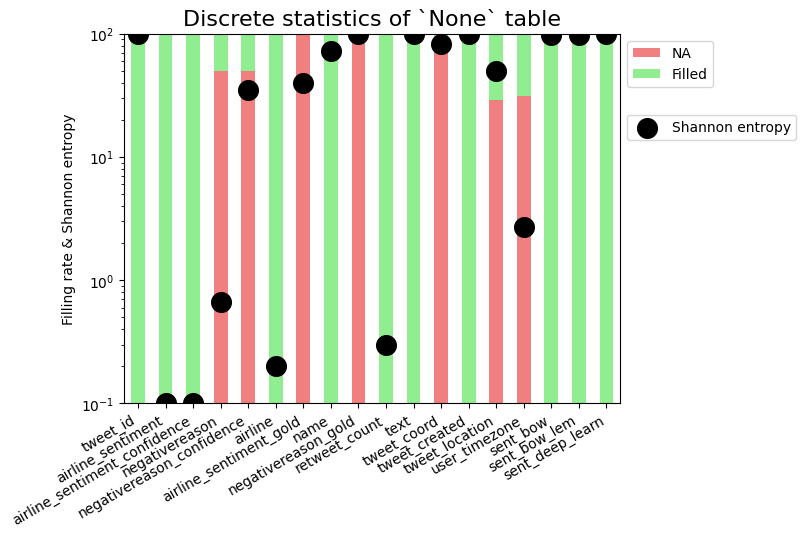

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sent_bow,sent_bow_lem,sent_deep_learn
tweet_id,,,,,,,,,,,,,,,,,
568215154569166848,positive,1.0,NaN,NaN,United,NaN,RobandMeg,NaN,0,@united we had a wonderful flight attendant na...,NaN,2015-02-18 17:07:04 -0800,"Staten Island, NY",Eastern Time (US & Canada),united wonderful flight attendant named leah l...,united wonderful flight attendant named leah l...,united we had a wonderful flight attendant nam...
568868703762296832,positive,1.0,NaN,NaN,Southwest,NaN,mcgibbon_keith,NaN,0,@SouthwestAir This has to be the best video I ...,NaN,2015-02-20 12:24:02 -0800,Ottawa Canada,Eastern Time (US & Canada),southwestair this best video seen ever teamspi...,southwestair this best video seen ever teamspi...,southwestair this has to be the best video i h...
567848852943953920,positive,1.0,NaN,NaN,United,NaN,mortgagejake,NaN,0,@united awesome. Thx. And thx for replying so ...,NaN,2015-02-17 16:51:31 -0800,toronto,Atlantic Time (Canada),united awesome thx and thx replying damn fast ...,united awesome thx and thx replying damn fast ...,united awesome . thx . and thx for replying so...
569188967180058625,negative,1.0,Can't Tell,0.6634,United,NaN,recon_love,NaN,0,@united Yeah that didn't happen!,NaN,2015-02-21 09:36:39 -0800,NaN,NaN,united yeah n't happen,united yeah n't happen,united yeah that did n't happen !
570078733735821313,negative,1.0,Flight Attendant Complaints,0.6720,United,NaN,throthra,NaN,0,"@united well, considering every agent before c...",NaN,2015-02-23 20:32:16 -0800,NaN,NaN,united well considering every agent claimed un...,united well considering every agent claimed un...,"united well , considering every agent before c..."


In [9]:
from tx_ml import load
from pepper_utils import show_discrete_stats

old_tweets = load('old_3k_sample_clean.csv')
print(old_tweets.shape)
show_discrete_stats(old_tweets.reset_index())
display(old_tweets.sample(5))

In [10]:
from tx_ml import old_encode_cats
import numpy as np

y_cat_num, l_cat = old_encode_cats(old_tweets.airline_sentiment)
print('catégories : ', l_cat)
display(np.unique(y_cat_num, return_counts=True))

catégories :  ['positive', 'negative']


(array([0, 1]), array([1500, 1500], dtype=int64))

In [11]:
from tx_ml import encode_cats

cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
print(cat_labels, len(cat_labels))
display(cat_codes.value_counts())

Index(['negative', 'positive'], dtype='object') 2


0    1500
1    1500
dtype: int64

In [12]:
from tx_ml import count_words

old_tweets['bow_len'] = old_tweets.sent_bow.apply(count_words)
print("max sent_bow sentence length : ", old_tweets.bow_len.max())

old_tweets['deep_learn_len'] = old_tweets.sent_deep_learn.apply(count_words)
print("max sent_deep_learn length : ", old_tweets.deep_learn_len.max())

max sent_bow sentence length :  22
max sent_deep_learn length :  42


In [13]:
from tx_ml import count_words

tweets['bow_len'] = tweets.sent_bow.apply(count_words)
print("max sent_bow sentence length : ", tweets.bow_len.max())

tweets['deep_learn_len'] = tweets.sent_deep_learn.apply(count_words)
print("max sent_deep_learn length : ", tweets.deep_learn_len.max())

max sent_bow sentence length :  22
max sent_deep_learn length :  38


# Bag of word - Tf-idf

## Préparation des phrases

In [14]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

old_count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
old_tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

old_sent_bow_lem = old_tweets.sent_bow_lem
old_c_sent_bow_lem = old_count_vectorizer.fit_transform(old_sent_bow_lem)
old_f_sent_bow_lem = old_tf_idf_vectorizer.fit_transform(old_sent_bow_lem)

In [15]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

sent_bow_lem = tweets.sent_bow_lem
c_sent_bow_lem = count_vectorizer.fit_transform(sent_bow_lem)
f_sent_bow_lem = tf_idf_vectorizer.fit_transform(sent_bow_lem)

Sparsity index: 0.17


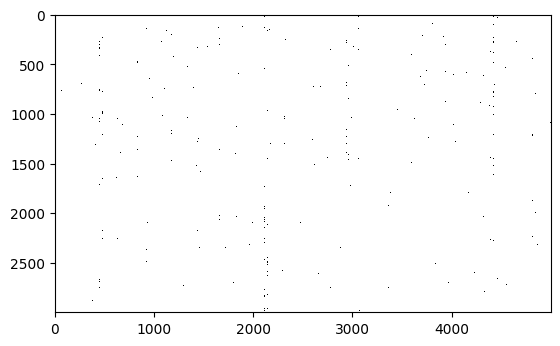

Sparsity index: 0.17


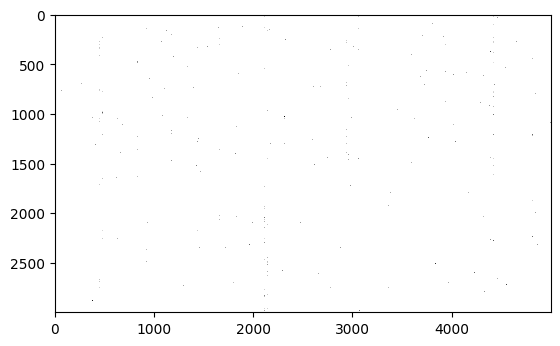

In [16]:
from tx_ml import show_sparsity

show_sparsity(old_c_sent_bow_lem)
show_sparsity(old_f_sent_bow_lem)

Sparsity index: 0.17


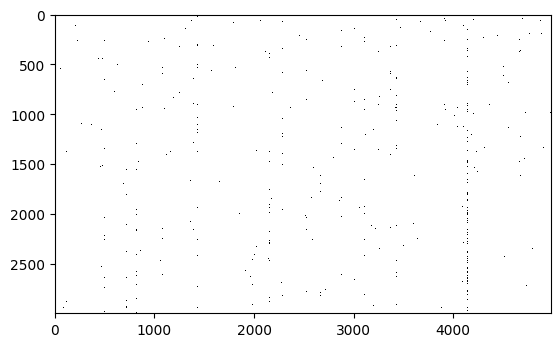

Sparsity index: 0.17


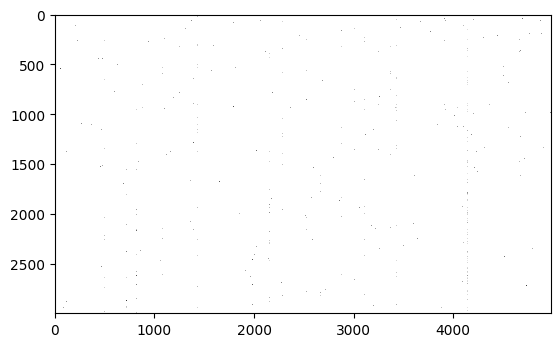

In [17]:
from tx_ml import show_sparsity

show_sparsity(c_sent_bow_lem)
show_sparsity(f_sent_bow_lem)

## Exécution des modèles

In [18]:
from tx_ml import tsne_kmeans_ari
print("CountVectorizer : ")
print("-----------------")
old_c_X_tsne, old_c_clu_labels, old_c_ari = tsne_kmeans_ari(old_c_sent_bow_lem, y_cat_num, l_cat)
print()
print("Tf-idf : ")
print("--------")
old_f_X_tsne, old_f_clu_labels, old_f_ari = tsne_kmeans_ari(old_f_sent_bow_lem, y_cat_num, l_cat)

CountVectorizer : 
-----------------
T-SNE time: 37.09s
KMeans time: 0.17s
ARI time: 0.00s
Total time : 37.26s

ARI : 0.525

Tf-idf : 
--------
T-SNE time: 35.94s
KMeans time: 0.34s
ARI time: 0.00s
Total time : 36.28s

ARI : 0.502


In [19]:
from tx_ml import tsne_kmeans_ari
print("CountVectorizer : ")
print("-----------------")
c_X_tsne, c_clu_labels, c_ari = tsne_kmeans_ari(c_sent_bow_lem, cat_codes, cat_labels)
print()
print("Tf-idf : ")
print("--------")
f_X_tsne, f_clu_labels, f_ari = tsne_kmeans_ari(f_sent_bow_lem, cat_codes, cat_labels)


CountVectorizer : 
-----------------
T-SNE time: 34.06s
KMeans time: 0.23s
ARI time: 0.00s
Total time : 34.29s

ARI : 0.1025

Tf-idf : 
--------
T-SNE time: 35.73s
KMeans time: 0.29s
ARI time: 0.00s
Total time : 36.02s

ARI : 0.1922


## Graphiques

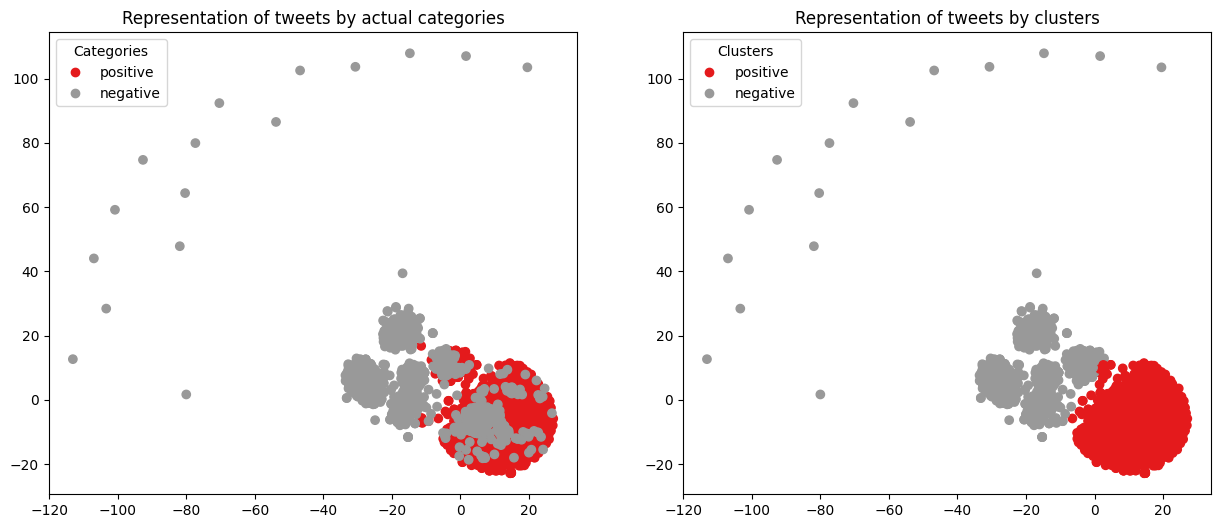

ARI :  0.5249856424186541


In [20]:
from tx_ml import show_tsne
show_tsne(y_cat_num, l_cat, old_c_X_tsne, old_c_clu_labels, old_c_ari)

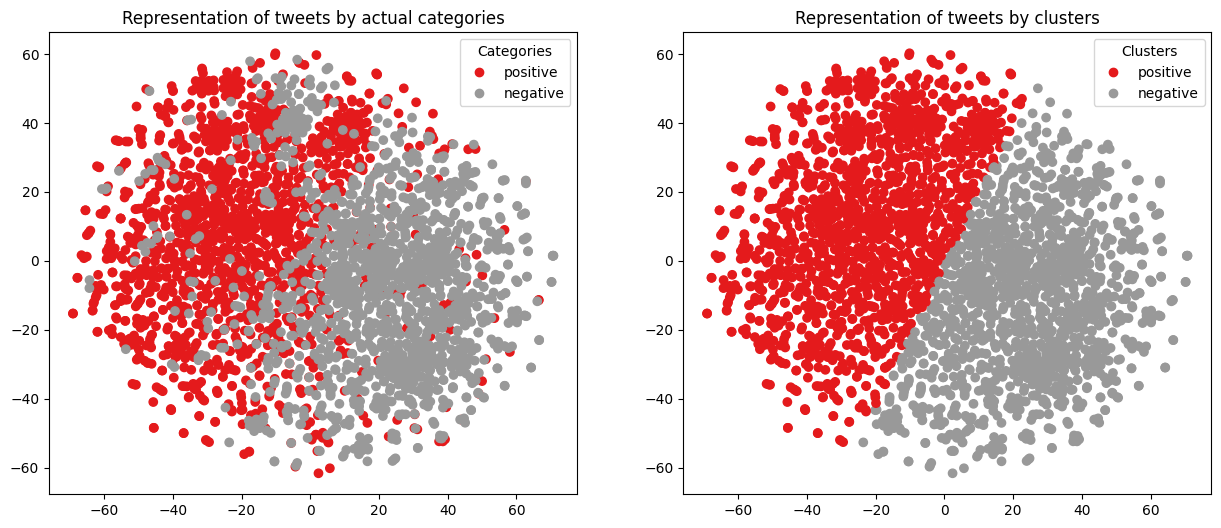

ARI :  0.502042474173476


In [21]:
from tx_ml import show_tsne
show_tsne(y_cat_num, l_cat, old_f_X_tsne, old_f_clu_labels, old_f_ari)

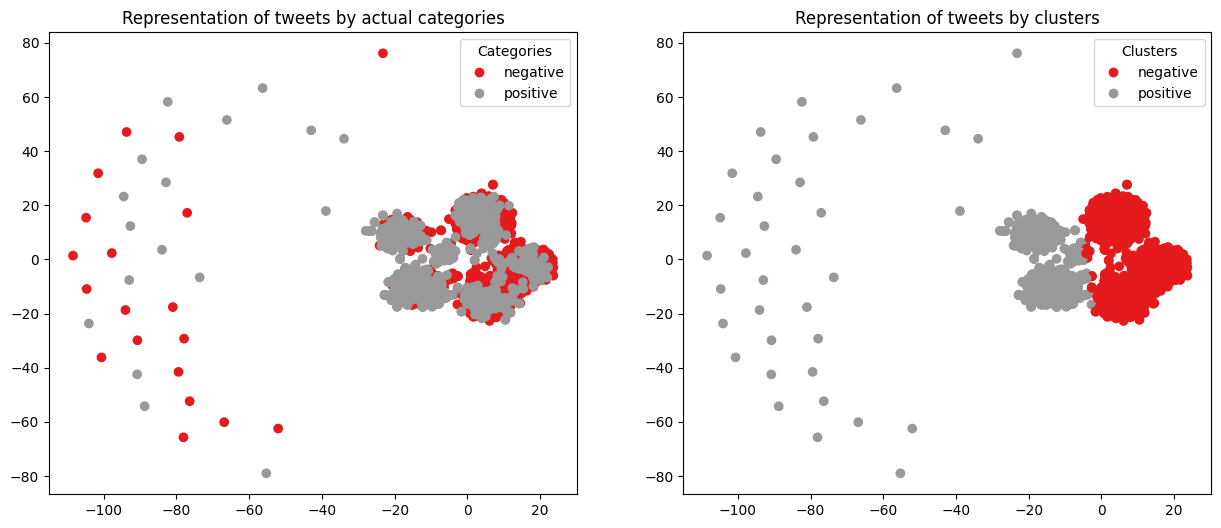

ARI :  0.10254500094844456


In [22]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, c_X_tsne, c_clu_labels, c_ari)

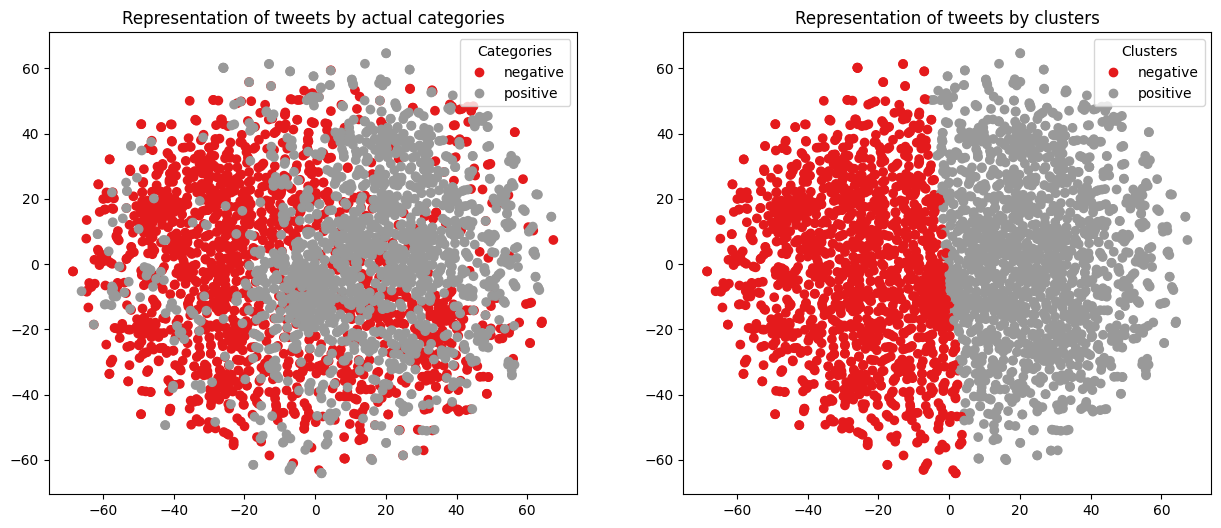

ARI :  0.19215991937137483


In [23]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, f_X_tsne, f_clu_labels, f_ari)

# Word2Vec

ARI : 0.3

Les deux fonctions suivantes concernent la construction d'un modèle d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. La première fonction `get_embedding_matrix` sert à créer la matrice d'embedding en utilisant le modèle Word2Vec et le tokenizer Keras. Le but est de convertir chaque mot en vecteur à partir du modèle Word2Vec, et de stocker ces vecteurs dans une matrice. La matrice aura la forme `(vocab_size, w2v_size)`, où `vocab_size` est la taille du vocabulaire du tokenizer Keras et `w2v_size` est la dimension du modèle Word2Vec.

La seconde fonction `get_embeddeding_model` sert à construire un modèle Keras qui prend en entrée des phrases tokenizées et renvoie les vecteurs d'embedding associés. Elle crée un modèle Keras avec une entrée de forme `(nombre de phrases, longueur maximale de la phrase)` et renvoie un vecteur d'embedding de longueur `w2v_size` pour chaque phrase. Les poids pré-entraînés de la matrice d'embedding sont attachés à la couche d'embedding du modèle.

## Création du modèle Word2Vec

In [24]:
from tx_ml import load
tweets = load('3k_sample_clean.csv')
sent_bow_lem = tweets.sent_bow_lem
display(sent_bow_lem)

tweet_id
567783978955993088                     southwestair checkin system poor
569686401735745536    americanair flight dfw 2463 cancelled flightle...
570139793608175616    americanair last year flight delayed cancelled...
568022411783888896    usairways 5534 that flight placed original fli...
569907336485019648    virginamerica let scanned passenger leave plan...
                                            ...                        
569907544124219392    americanair thanks response better nothing ahe...
569958247412723712                                    united thank help
570274750821486592                                 usairways thank much
569353033915584513    jetblue maddie_flood your airline sound outsta...
569204185318723584              jetblue thank alicia exceptionalservice
Name: sent_bow_lem, Length: 3000, dtype: object

Globals

In [25]:
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 24 # adapt to length of sentences

List of lists of Gesim preprocessed words

In [26]:
from tx_ml import gesim_simple_preprocess
sents = gesim_simple_preprocess(sent_bow_lem)
print(sents[:5])

[['southwestair', 'checkin', 'system', 'poor'], ['americanair', 'flight', 'dfw', 'cancelled', 'flightled', 'tonight', 'called', 'left', 'number', 'call', 'back', 'hrs', 'please', 'help'], ['americanair', 'last', 'year', 'flight', 'delayed', 'cancelled', 'flightled', 'done'], ['usairways', 'that', 'flight', 'placed', 'original', 'flight', 'charlotte', 'cancelled', 'flightled', 'now', 'hr', 'delay'], ['virginamerica', 'let', 'scanned', 'passenger', 'leave', 'plane', 'told', 'someone', 'remove', 'bag', 'st', 'class', 'bin', 'uncomfortable']]


In [27]:
from tx_ml import fit_word2vec
w2v_model = fit_word2vec(sents)

Build & train Word2Vec model ...
Vocabulary size: 4771
Word2Vec trained


In [28]:
model_vectors = w2v_model.wv
print(f"model_vectors ({len(model_vectors)}", model_vectors)
w2v_words = model_vectors.index_to_key
print(f"w2v_words ({len(w2v_words)})", w2v_words[:10])
print("flight vector", model_vectors['flight'][:50])

model_vectors (4771 KeyedVectors<vector_size=300, 4771 keys>
w2v_words (4771) ['flight', 'united', 'usairways', 'southwestair', 'americanair', 'jetblue', 'thanks', 'thank', 'service', 'customer']
flight vector [-0.38878053  0.8314128   0.24594098  0.20739564 -0.6608683   0.6101564
 -0.21071398  0.22837697  0.29838884 -1.2215672  -0.27085367  0.8623078
 -0.00181589  0.6797285   0.26040336  0.73613364 -0.21162263 -0.7144062
  0.7450121  -0.0315627   0.5278007   0.18802632 -0.9371986   0.64978075
  0.19938248  0.4402149   0.03680236  0.35999355  0.02427504  0.06083962
  0.19267038 -0.56973296 -0.49546623  0.83517283  0.02171487 -0.02714447
 -0.14397155  0.7921458  -0.26935017 -0.30026844  0.12319783  0.15086038
 -0.02671344 -0.1038306  -0.84208006  0.72899354  0.43081897  0.44013628
  0.4718875   0.13039008]


In [29]:
from tx_ml import fit_keras_tokenizer
keras_tokenizer, x_sents = fit_keras_tokenizer(sents)
display(keras_tokenizer)
print(x_sents.shape)
display(x_sents)

Fit Tokenizer ...
Number of unique words: 4772


(3000, 24)


array([[   4,  506,  129, ...,    0,    0,    0],
       [   5,    1,  206, ...,    0,    0,    0],
       [   5,   70,  161, ...,    0,    0,    0],
       ...,
       [   3,    8,   37, ...,    0,    0,    0],
       [   6, 4770,  114, ...,    0,    0,    0],
       [   6,    8, 4771, ...,    0,    0,    0]])

## Création de la matrice d'embedding

In [30]:
from tx_ml import get_embedding_matrix
embedding_matrix = get_embedding_matrix(w2v_model, keras_tokenizer)

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix:  (4772, 300)


## Création du modèle d'embedding

In [31]:
from tx_ml import get_embedding_model
keras_model = get_embedding_model(x_sents, w2v_model, keras_tokenizer, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           1431600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,431,600
Trainable params: 1,431,600
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [32]:
embeddings = keras_model.predict(x_sents)
embeddings.shape

94/94 [==============================] - 0s 1ms/step


(3000, 300)

In [33]:
from tx_ml import tsne_kmeans_ari
wve_X_tsne, wve_clu_labels, wve_ari = tsne_kmeans_ari(embeddings, cat_codes, cat_labels)

T-SNE time: 37.02s
KMeans time: 0.25s
ARI time: 0.00s
Total time : 37.27s

ARI : 0.3502


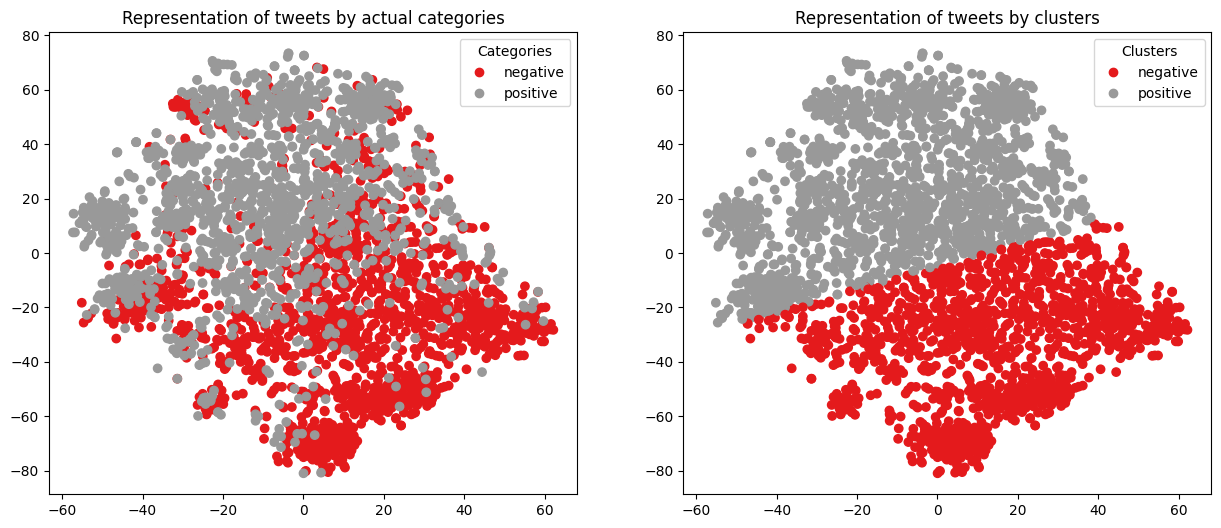

ARI :  0.3502490219051282


In [34]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, wve_X_tsne, wve_clu_labels, wve_ari)

# BERT

ARI : 0.5

In [35]:
from tx_ml import load, encode_cats
from pepper_utils import show_discrete_stats

tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [36]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


## BERT HuggingFace

### 'bert-base-uncased'

In [37]:
from transformers import TFAutoModel
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
# Création des features
from tx_ml import extract_bert_sentence_embeddings
bert_features, _ = extract_bert_sentence_embeddings(
    model,
    model_type,
    sents, 
    max_length,
    batch_size,
    mode='HF'
)

300/300 [==============================] - 260s 847ms/step


In [39]:
from tx_ml import tsne_kmeans_ari
bert_X_tsne, bert_clu_labels, bert_ari = tsne_kmeans_ari(bert_features, cat_codes, cat_labels)

T-SNE time: 41.71s
KMeans time: 0.32s
ARI time: 0.00s
Total time : 42.03s

ARI : 0.4695


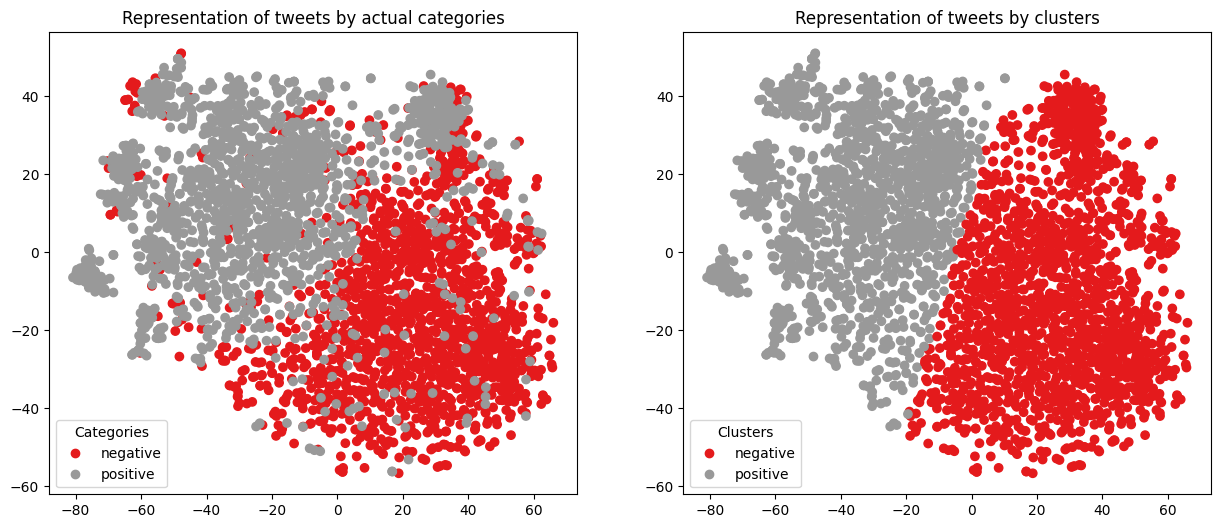

ARI :  0.469507159920403


In [40]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, bert_X_tsne, bert_clu_labels, bert_ari)

# USE - Universal Sentence Encoder

ARI : 0.6

In [41]:
from tx_ml import load, encode_cats
from pepper_utils import show_discrete_stats

tweets = load('3k_sample_clean.csv')
cat_codes, cat_labels = encode_cats(tweets.airline_sentiment)
sents = tweets.sent_deep_learn

In [42]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available:", n_gpu)
print("Built with cuda:", tf.test.is_built_with_cuda())

Tensorflow version: 2.11.0
Num GPUs Available: 0
Built with cuda: False


In [43]:
# Création des features
from tx_ml import extract_use_sentence_embeddings
use_features = extract_use_sentence_embeddings(sents)

USE time: 2.50s


In [44]:
from tx_ml import tsne_kmeans_ari
use_X_tsne, use_clu_labels, use_ari = tsne_kmeans_ari(use_features, cat_codes, cat_labels)

T-SNE time: 39.84s
KMeans time: 0.32s
ARI time: 0.01s
Total time : 40.16s

ARI : 0.6031


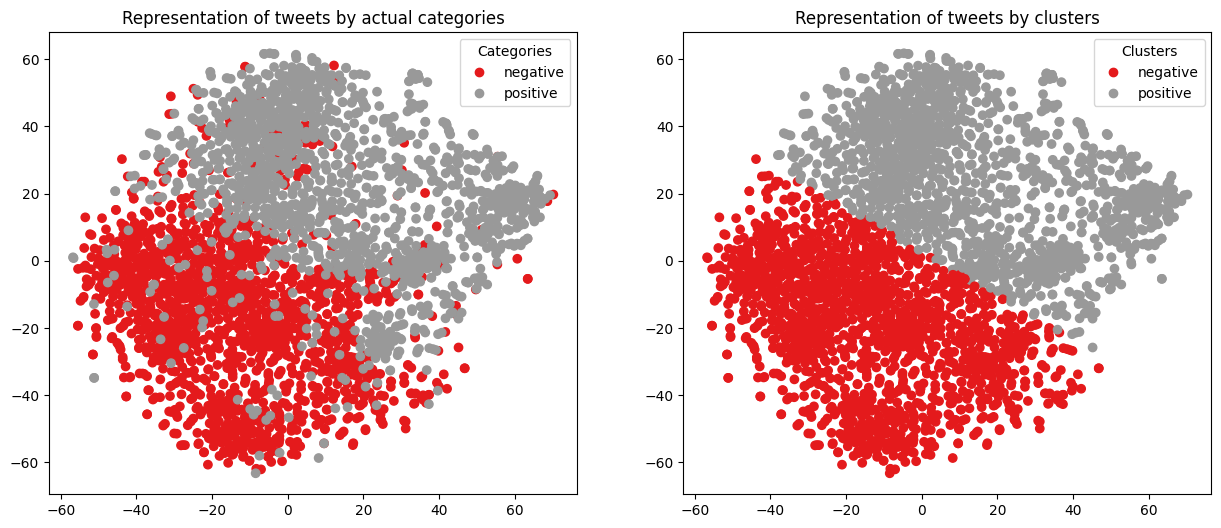

ARI :  0.6030788494132489


In [45]:
from tx_ml import show_tsne
show_tsne(cat_codes, cat_labels, use_X_tsne, use_clu_labels, use_ari)